In [1]:
# Custom Imports
from polymer_utils import analysis, general, filetree, molutils
from polymer_utils import simulation as polysim

from polymer_utils import charging
from polymer_utils.charging.types import AtomIDMap, ResidueChargeMap
from polymer_utils.charging.residues import ChargedResidue

from polymer_utils.representation import PolymerDir, PolymerDirManager
from polymer_utils.representation import LOGGER as polylogger
from polymer_utils.solvation.solvents import WATER_TIP3P
from polymer_utils.analysis import trajectory, propplot
from polymer_utils.logutils import config_mlf_handler, MultiStreamFileHandler
from polymer_utils.graphics import rdkdraw

# General Imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL.Image import Image # for typing
from datetime import datetime

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree

# Logging and Shell
from IPython.display import clear_output
import subprocess
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.units import unit
from openff.interchange import Interchange

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openmm.openmm import MonteCarloBarostat
from openff.toolkit.utils.exceptions import ConformerGenerationError
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper

from openmm import LangevinMiddleIntegrator, Context
from openmm.vec3 import Vec3
from openmm.app import Simulation, PDBReporter, StateDataReporter

from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# Static Paths
RESOURCE_PATH = Path('resources')
COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs')

## Configuring and (re)loading polymers, setting solvents, checking validity

In [2]:
reset      = False #True
purge_sims = True #False 
purge_logs = False

poly_source_path = COMPAT_PDB_PATH / 'simple_polymers_updated'
solv_template    = RESOURCE_PATH/'inp_templates'/'solv_polymer_template_box.inp'
desired_solvents = (WATER_TIP3P,) # (None,)
exclusion = 1.0*nanometer

# Define derived paths and create manager
collection_path  = COLL_PATH / poly_source_path.name
structure_path   = poly_source_path / f'{poly_source_path.name}_structures'
monomer_path     = poly_source_path / f'{poly_source_path.name}_monomers'

mgr = PolymerDirManager(collection_path)

# Perform manager setup / purge actions
if purge_logs: # NOTE : must be done BEFORE log FileHandler is created, as this will destroy it's output as well
    mgr.purge_logs(really=True)

creation_logger = logging.getLogger('polymer_setup')
logfile_path = mgr.log_dir/f'Setup_{general.timestamp_now()}.log'

with MultiStreamFileHandler(logfile_path, loggers=[creation_logger, polylogger], proc_name=f'Creation of collection "{mgr.collection_dir.name}"'):
    if reset:
        mgr.purge_collection(really=True, purge_logs=False) # Explicitly DON'T purge logs here (will be done prior to entering log loop)

    if purge_sims:
        mgr.purge_sims(really=True)

    if not mgr.mol_dirs: # will be empty if not yet instantiated or if reset prior
        mgr.populate_collection(struct_dir=structure_path, monomer_dir=monomer_path)
        mgr.solvate_collection(desired_solvents, template_path=solv_template, exclusion=exclusion)

INFO:8729352566824:Creation of collection "simple_polymers_updated" completed in 0:00:00.066138



In [84]:
# Selecting subset of molecules which is suitable for ABE10 charging and subsequent simulation
HARD_POLYMERS = ['vulcanizedrubber', 'polyphenylenesulfone', 'polyethylene', 'polyphenyleneI'] # pathological or otherwise difficult-to-run polymers that I've encountered
EASY_POLYMERS = ['polyvinylchloride_solv_water', 'polyethylmethacrylate_solv_water'] + ['naturalrubber_solv_water', 'PEO_PLGA_solv_water'] # the quickest-to-charge and -to-simulate polymers in the sample set

MolFilter = Callable[[PolymerDir], bool]
whitelisted  = lambda mol_dir : mol_dir.base_mol_name not in HARD_POLYMERS
matchable    = lambda mol_dir : mol_dir.has_monomer_data
AM1_sized    = lambda mol_dir : 0 < mol_dir.n_atoms <= 300
good_solvent = lambda mol_dir : mol_dir.solvent in desired_solvents

filters : tuple[MolFilter] = (whitelisted, matchable, AM1_sized, good_solvent)
valid_mols = {
    mol_dir.mol_name : mol_dir
        for mol_dir in mgr.mol_dirs_list
            if all(_filter(mol_dir) for _filter in filters)
}

# display to check that loading has gone as planned
# for pdir in sorted(mgr.mol_dirs_list, key = lambda mdir : mdir.n_atoms):
#     print(pdir.mol_name)
# print(mgr.all_completed_sims)
print(valid_mols.keys())

dict_keys(['peg_modified_solv_water'])


## Charge and sim loop V2

In [4]:
# DEFINE TARGET MOLECULES AND FORCEFIELD
# sample_mols = valid_mols
sample_mols = EASY_POLYMERS
# sample_mols = ['polyvinylchloride_solv_water']
main_ff_xml = RESOURCE_PATH/'force_fields'/'openff_constrained-2.0.0.offxml'
# main_ff_xml = RESOURCE_PATH/'force_fields'/'openff_unconstrained-2.0.0.offxml'

# CHARGING PARAMETERS
overwrite_ff_xml     = True
overwrite_chg_json   = True
distrib_mono_charges = True

strict   = True
verbose  = False

avg_charge_method = 'ABE10_exact' # 'Espaloma_AM1BCC'

# SIMULATION PARAMETERS
run_sims = True
# sim_param_path = RESOURCE_PATH/'sim_templates'/'debug_sim.json'
sim_param_path = RESOURCE_PATH/'sim_templates'/'half_standard_sim.json'
# sim_param_path = RESOURCE_PATH/'sim_templates'/'standard_sim.json'
sim_params = polysim.SimulationParameters.from_file(sim_param_path)

# ANALYSIS PARAMETERS
perform_analysis = True
traj_sample_interval = 5 # interval between consecutive time points for trajectory analysis (needed for longer sims)

In [5]:
# PRE-FLIGHT CALCULATIONS
if avg_charge_method == 'ABE10_averaged':
    raise ValueError('Charge averaging must be performed over a non-averaged (i.e. pure) set of charges')

sample_dirs = {
    mol_name : mgr.mol_dirs[mol_name] # TOSELF : deliberately not using .get() so this raises an easier-to-debug KeyError
        for mol_name in sample_mols
}

step_names = {
    'charging' : True,
    'simulation' : run_sims,
    'analysis' : perform_analysis
}
action_str = ' & '.join([
    step_name
        for step_name, perform_step in step_names.items()
            if perform_step
])

print(sim_params)
print(sim_params.num_steps, sim_params.record_freq, action_str)
print(sample_dirs.keys())

SimulationParameters(total_time=Quantity(value=5, unit=nanosecond), num_samples=1250, charge_method='ABE10_averaged', reported_state_data={'step': True, 'time': True, 'potentialEnergy': True, 'kineticEnergy': True, 'totalEnergy': True, 'temperature': True, 'volume': True, 'density': True, 'progress': False, 'remainingTime': False, 'speed': True, 'elapsedTime': True}, timestep=Quantity(value=2, unit=femtosecond), temperature=Quantity(value=300, unit=kelvin), pressure=Quantity(value=1, unit=atmosphere), friction_coeff=Quantity(value=1, unit=/picosecond), barostat_freq=25)
2500000 2000 charging & simulation & analysis
dict_keys(['polyvinylchloride_solv_water', 'polyethylmethacrylate_solv_water', 'naturalrubber_solv_water', 'PEO_PLGA_solv_water'])


In [6]:
# Functions for performing primary charging, sim, and analysis actions
def obtain_partial_charges(mol_dir : PolymerDir, main_logger : logging.Logger, avg_charge_method : str, overwrite_chg_json : bool,
                            overwrite_ff_xml : bool, main_ff_xml : Path, strict : bool, verbose : bool) -> dict[str, Molecule]:
    '''Step (1) : ensure a PolymerDir has all partial charge sets'''
    # 0) LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
    if not mol_dir.has_monomer_data:
        raise FileExistsError(f'No monomer JSONs found for {mol_dir.mol_name}')

    # 1) ENSURING CHARGES AND RELATED FILES FOR ALL CHARGING METHODS EXIST
    main_logger.info('(1) Acquiring partial charges')

    cmols = {}
    for chg_method, chgr_type in charging.application.CHARGER_REGISTRY.items():
        chgr = chgr_type()

        if chg_method == 'ABE10_averaged': # !NOTE! - critical that this not be the first key in the registry (has nothing to average over from scratch)
            main_logger.info(f'Averaging charges over {mol_dir.mol_name} residues')
            cmol = cmols[avg_charge_method] # obtain the pure charged molecule from which to draw charges for averaging
            avgd_res, atom_id_mapping = charging.averaging.get_averaged_charges(cmol, monomer_data=mol_dir.monomer_data)
            residue_charges = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgd_res}
            chgr.set_residue_charges(residue_charges)
            
            if (mol_dir.monomer_file_chgd is None) or overwrite_chg_json: # can only reach this branch if a json is present but isn't identified as charged within the PolymerDir
                main_logger.warning('Generating new charged JSON monomer file')
                mol_dir.create_charged_monomer_file(residue_charges)

                monomer_data = mol_dir.monomer_data_charged # double check that the charged data is in fact loadable
                main_logger.info('Acquired charge-averaged monomer JSON')

        cmol = mol_dir.assert_charges_for(chgr, strict=strict, verbose=verbose)
        cmols[chg_method] = cmol
    
    if (mol_dir.ff_file is None) or overwrite_ff_xml: # can only reach if a charged monomer json already exists
        main_logger.warning('Generating new Force Field XML with Library Charges')
        forcefield, lib_chgs = mol_dir.create_FF_file(xml_src=main_ff_xml, return_lib_chgs=True)
    main_logger.info('Acquired Force Field file with Library Charges')

    return cmols

def run_simulation(mol_dir : PolymerDir, main_logger : logging.Logger, sim_params : polysim.SimulationParameters) -> None:
    '''Step (2) : run OpenMM sim for target molecule'''
    main_logger.info('(2) Preparing simulation')
    sim_folder = mol_dir.make_sim_dir()
    sim_params.to_file(sim_folder/'simulation_parameters.json')

    main_logger.info('Creating Simulation from Interchange')
    interchange = mol_dir.interchange(sim_params.charge_method)
    barostat    = MonteCarloBarostat(sim_params.pressure, sim_params.temperature, sim_params.barostat_freq)
    integrator  = LangevinMiddleIntegrator(sim_params.temperature, sim_params.friction_coeff, sim_params.timestep)
    sim = polysim.create_simulation(interchange, integrator, forces=[barostat])

    main_logger.info(f'Running {sim_params.total_time} OpenMM sim at {sim_params.temperature} and {sim_params.pressure} for {sim_params.num_steps} steps')
    polysim.run_simulation(sim, output_folder=sim_folder, output_name=mol_dir.mol_name, sim_params=sim_params)

def perform_prop_analysis(mol_dir : PolymerDir, main_logger : logging.Logger, sim_params : polysim.SimulationParameters, traj_sample_interval : int):
    '''Step (3) : analyze trajectories to obtain polymer property data'''
    main_logger.info('(3) Analyzing trajectories')

    # aqcuire files for all information
    sim_folder = mol_dir.newest_sim_dir
    main_logger.info(f'Acquiring trajectory data from {sim_folder}')
    # sim_params_path = next(sim_folder.glob('*_parameters.json'))
    # state_data_path = next(sim_folder.glob('*_data.csv'))
    # sim_params = SimulationParameters.from_file(sim_params_path)
    # state_data = pd.read_csv(state_data_path)

    # load simulation frames into an analyzable trajectory
    main_logger.info('Loading trajectory for analysis')
    traj_path = next(sim_folder.glob('*_traj.pdb'))
    traj = trajectory.load_traj(traj_path, topo_path=mol_dir.structure_file, sample_interval=traj_sample_interval, remove_solvent=True)

    # save and plot RDF data
    main_logger.info('Determining pairwise radial distribution functions')
    rdf_dataframe = trajectory.acquire_rdfs(traj, max_rad=1.0*nanometer)
    rdf_dataframe.to_csv(sim_folder/'rdfs.csv')
    rdf_fig, rdf_ax = propplot.plot_rdfs(rdf_dataframe, scale=15.0)
    rdf_fig.suptitle(f'Pairwise Radial Distribution Functions - {mol_dir.mol_name}')
    rdf_fig.savefig(sim_folder/f'RDFs.png', bbox_inches='tight')
    plt.close()

    # save and plot property data
    main_logger.info('Determining polymer shape properties')
    prop_dataframe = trajectory.acquire_time_props(traj, properties=analysis.DEFAULT_PROPS, time_points=sim_params.time_points[::traj_sample_interval]) 
    prop_dataframe.to_csv(sim_folder/'time_series.csv')
    prop_fig, prop_ax = propplot.plot_time_props(prop_dataframe, scale=18.0)
    prop_fig.suptitle(f'Polymer Shape Properties - {mol_dir.mol_name}')
    prop_fig.savefig(sim_folder/f'shape_props.png', bbox_inches='tight')
    plt.close()
    
    main_logger.info('Exported trajectory analysis data and plots')

In [7]:
# BEGIN CHARGING / SIM LOOP - Perform charge averaging on all target molecules which don't already have averaged LCs; Load forcefield for those which already do 
main_logger = logging.getLogger(__name__)
loggers = [main_logger, polylogger] # loggers from all modules which produce logging output
main_logfile_path = mgr.log_dir/f'{action_str}_{general.timestamp_now()}.log'

with MultiStreamFileHandler(main_logfile_path, loggers=loggers, proc_name=f'{action_str.capitalize()} loop'):
    for i, (mol_name, mol_dir) in enumerate(sample_dirs.items()):
        main_logger.info(f'Current molecule: "{mol_name}" ({i + 1}/{len(sample_dirs)})') # +1 converts to more human-readable 1-index for step count

        mol_dir_logfile_path = mol_dir.logs/f'{general.timestamp_now()}.log'
        
        with MultiStreamFileHandler(mol_dir_logfile_path, loggers=loggers, proc_name=f'{mol_name} {action_str}'): # also log actions to individual PolymerDirs
            cmols = obtain_partial_charges(mol_dir, main_logger, avg_charge_method, overwrite_chg_json, overwrite_ff_xml, main_ff_xml, strict, verbose)

            if run_sims:
                run_simulation(mol_dir, main_logger, sim_params)
            
            if perform_analysis:
                perform_prop_analysis(mol_dir, main_logger, sim_params, traj_sample_interval)

INFO:__main__:Current molecule: "polyvinylchloride_solv_water" (1/4)
INFO:__main__:(1) Acquiring partial charges
INFO:polymer_utils.representation:Found existing partial charges for "ABE10_exact"
INFO:polymer_utils.representation:Found existing partial charges for "Espaloma_AM1BCC"
INFO:__main__:Averaging charges over polyvinylchloride_solv_water residues
INFO:polymer_utils.representation:Created new monomer file for polyvinylchloride_solv_water with monomer-averaged charge entries
INFO:__main__:Acquired charge-averaged monomer JSON
INFO:polymer_utils.representation:Found existing partial charges for "ABE10_averaged"
INFO:polymer_utils.representation:Detected solvent "water", merged solvent and molecule force field
INFO:polymer_utils.representation:Generated new Force Field XML with Library Charges
INFO:__main__:Acquired Force Field file with Library Charges
INFO:__main__:(2) Preparing simulation
INFO:__main__:Creating Simulation from Interchange
INFO:polymer_utils.representation:Loadi

(<Figure size 800x800 with 2 Axes>, <AxesSubplot: >)

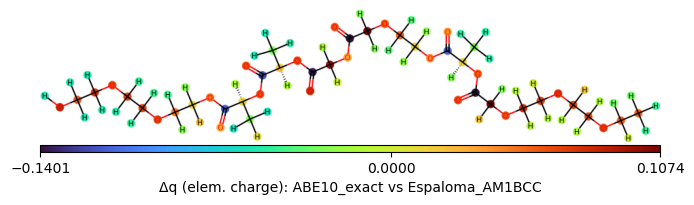

In [8]:
mol_dir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', converter='SMARTS')